# 1. Build your own convolutional neural network using pytorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
from torchvision import datasets,transforms
import numpy as np 
from torch.utils.data import Dataset, DataLoader
import os 
from PIL import Image
import pandas as pd

In [2]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),


    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),


    nn.Linear(128 * 14 * 14, 256),  
    nn.ReLU(),
    nn.Dropout(p=0.5), 

    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5), 

    nn.Linear(128, 3)  
)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): MaxPool2d(kernel_size=2, stri

# 2. Train your model using dog heart dataset (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 

### (1) use torchvision.datasets.ImageFolder for the training dataset
### (2) use custom dataloader for test dataset (return image tensor and file name)

In [4]:


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),

])

train_dataset = datasets.ImageFolder(root="/kaggle/input/train-12/Train", transform=transform)
validation_dataset = datasets.ImageFolder(root="/kaggle/input/valid-12/Valid", transform=transform)

In [5]:
class CustomTestDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, fname) for fname in os.listdir(root) if fname.lower().endswith(('png', 'jpg', 'jpeg', 'tif', 'bmp'))]
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, index):
        file_path = self.image_paths[index]
        image = Image.open(file_path).convert("L")

        if self.transform:
            image = self.transform(image)
        file_name = os.path.basename(file_path)

        return image, file_name  

test_dataset = CustomTestDataset(root="/kaggle/input/test-12/Test", transform=transform)

In [6]:

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

In [7]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


num_epochs = 100
best_val_loss = float("inf")  
best_val_accuracy = 0         

best_model_acc_path = "best_model_acc.pth"  
best_model_loss_path = "best_model_loss.pth"  
last_model_path = "last_model.pth"  


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val


    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_acc_path)
        print(f" Best Accuracy Model Saved: {val_accuracy:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_loss_path)
        print(f" Best Loss Model Saved: {val_loss:.4f}")
    

    torch.save(model.state_dict(), last_model_path)
    print(f" Last Model Saved at Epoch {epoch+1}.")

print("\nTraining Complete")




Epoch 1/100
Train Loss: 1.9693, Train Accuracy: 40.69%
Validation Loss: 1.1328, Validation Accuracy: 38.00%

 Best Accuracy Model Saved: 38.00%
 Best Loss Model Saved: 1.1328
 Last Model Saved at Epoch 1.
Epoch 2/100
Train Loss: 0.9881, Train Accuracy: 44.48%
Validation Loss: 1.0691, Validation Accuracy: 39.50%

 Best Accuracy Model Saved: 39.50%
 Best Loss Model Saved: 1.0691
 Last Model Saved at Epoch 2.
Epoch 3/100
Train Loss: 0.9511, Train Accuracy: 44.34%
Validation Loss: 1.0458, Validation Accuracy: 34.50%

 Best Loss Model Saved: 1.0458
 Last Model Saved at Epoch 3.
Epoch 4/100
Train Loss: 0.9143, Train Accuracy: 45.34%
Validation Loss: 1.0265, Validation Accuracy: 38.00%

 Best Loss Model Saved: 1.0265
 Last Model Saved at Epoch 4.
Epoch 5/100
Train Loss: 0.9129, Train Accuracy: 45.99%
Validation Loss: 1.0275, Validation Accuracy: 47.00%

 Best Accuracy Model Saved: 47.00%
 Last Model Saved at Epoch 5.
Epoch 6/100
Train Loss: 0.9217, Train Accuracy: 44.63%
Validation Loss: 1.01

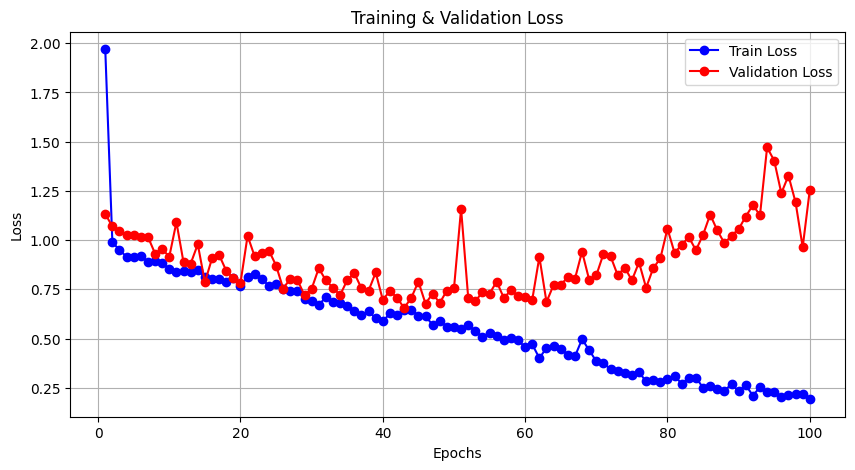

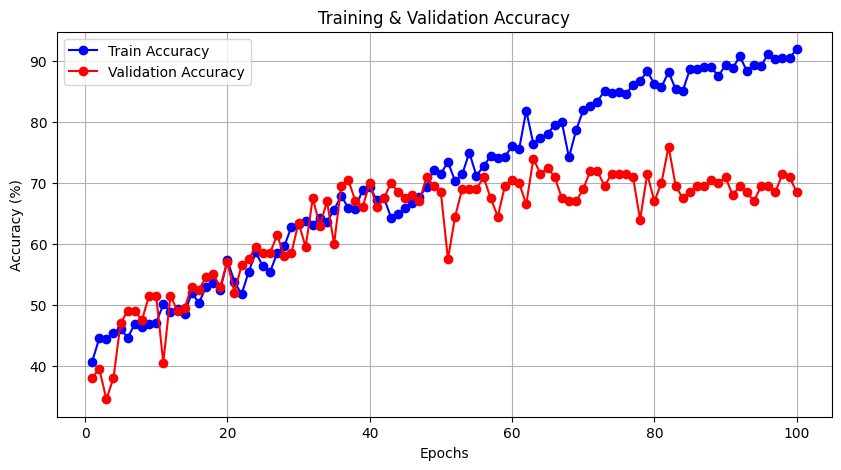

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", color="blue", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", color="red", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.savefig("loss_curve.png")  
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", color="blue", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", color="red", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()
plt.savefig("accuracy_curve.png")  
plt.show()

In [9]:

def save_predictions(model, model_name, filename):
    model.eval() 
    predictions = []
    
    with torch.no_grad(): 
        for image, file in test_dataset:
            image = image.to(device) 
            output = model(image.unsqueeze(0)) 
            _, predicted = torch.max(output, 1) 
            predictions.append((file, predicted.item()))  
    
    df = pd.DataFrame(predictions, columns=["Filename", "Predicted_Class"])
    csv_path = f"{filename}.csv"
    df.to_csv(csv_path, index=False, header=False)
    print(f"Predictions saved to {csv_path}")


best_model_acc = model
best_model_acc.load_state_dict(torch.load("best_model_acc.pth", map_location=device))
save_predictions(best_model_acc, "Best Accuracy", "predictions_best_acc")

best_model_loss = model
best_model_loss.load_state_dict(torch.load("best_model_loss.pth", map_location=device))
save_predictions(best_model_loss, "Best Loss", "predictions_best_loss")


last_model = model
last_model.load_state_dict(torch.load("last_model.pth", map_location=device))
save_predictions(last_model, "Last Model", "predictions_last_model")

<ipython-input-9-28ea22890459>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_acc.load_state_dict(torch.load("best_model_acc.pth", map_location=device))


Predictions saved to predictions_best_acc.csv ✅


<ipython-input-9-28ea22890459>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_loss.load_state_dict(torch.load("best_model_loss.pth", map_location=device))


Predictions saved to predictions_best_loss.csv ✅


<ipython-input-9-28ea22890459>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  last_model.load_state_dict(torch.load("last_model.pth", map_location=device))


Predictions saved to predictions_last_model.csv ✅


# 3. Evaluate your model using the developed software

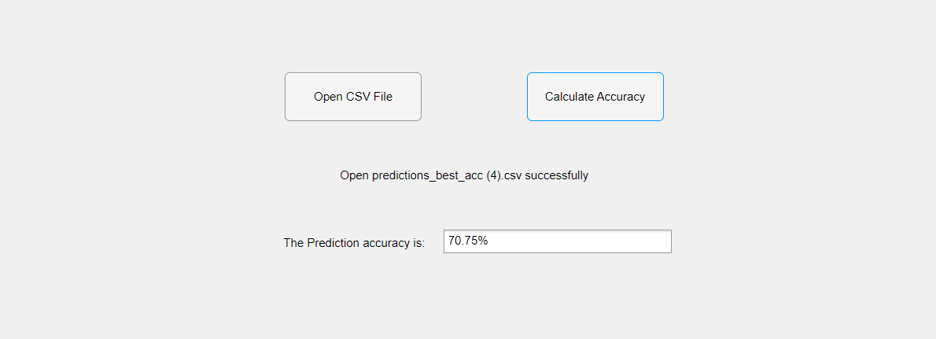

# 4. Compare results with [RVT paper](https://www.nature.com/articles/s41598-023-50063-x). Requirement: performance is better than VGG16: 75%

When comparing the performance of the custom CNN model with VGG16, it’s important to consider both accuracy and efficiency. The custom model achieved a test accuracy of 70.75%, slightly below VGG16’s 74.8%, demonstrating its effectiveness for the task. While VGG16 offers marginally better accuracy, it is a much deeper and more complex architecture that demands greater computational resources and longer training times. In contrast, the custom model is simpler, faster to train, and more efficient, making it a practical alternative—especially when resources are limited. With further optimization, such as tuning hyperparameters or enhancing regularization, the custom model has potential to narrow the performance gap even further, offering a strong balance between accuracy and efficiency.

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link and GitHub weight link here.

https://github.com/DushyanthReddy123/CNN-dog-cardiomegaly
https://www.researchgate.net/publication/390177098_Convolutional_Neural_Network_for_dog_cardiomegaly_assessment

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points


(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 75 % -->10 points
     < 55 % -->0 points
     >= 55 % & < 75% --> 0.5 point/percent
     

(6). Discussion - 10 points